In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [24]:
len(words)

32033

In [37]:
# build the vocab of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
chars
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [26]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X,Y = [],[]
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xtes,Ytes = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [132]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layers of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size,n_embd), generator = g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/ (n_embd*block_size)**0.5
b1 = torch.randn(n_hidden, generator= g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [133]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layers pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits,Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break
    


      0/ 200000: 3.3179


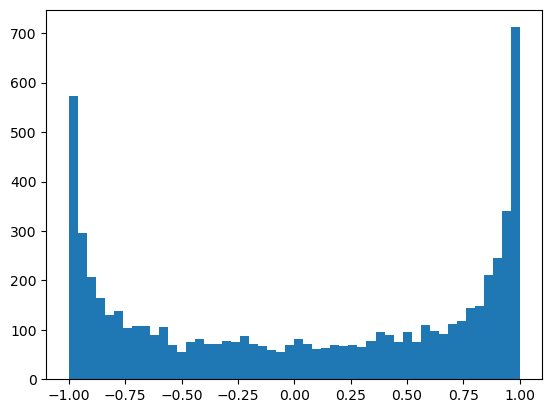

In [134]:
plt.hist(h.view(-1).tolist(),50);


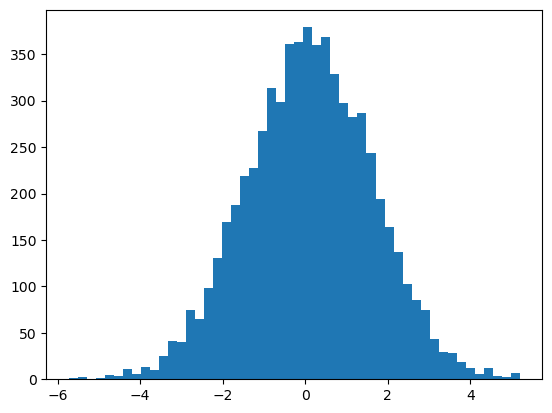

In [135]:
plt.hist(hpreact.view(-1).tolist(),50);

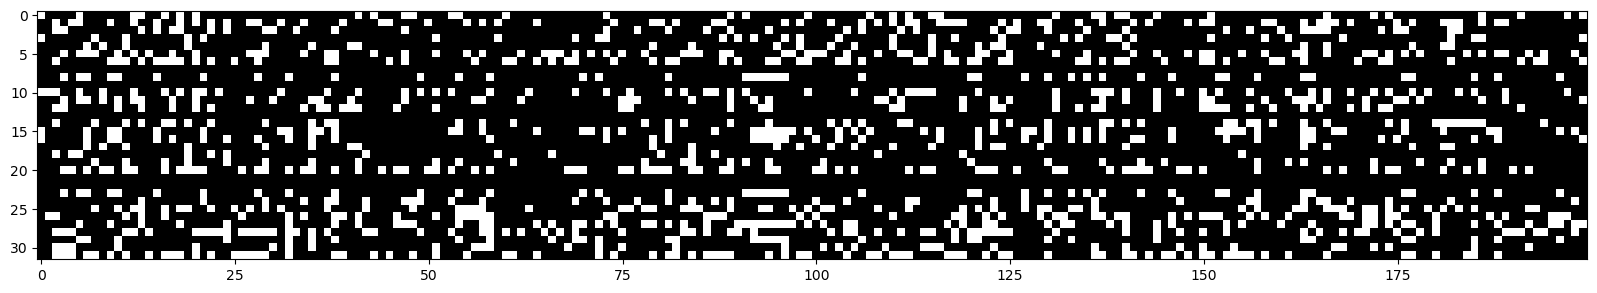

In [117]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation='nearest')

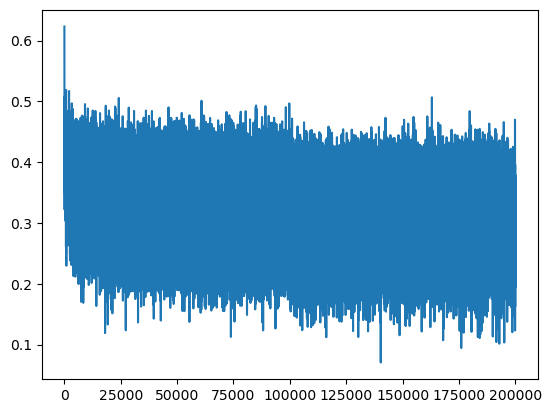

In [118]:
plt.plot(lossi)

In [119]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train':{Xtr,Ytr},
        'val':{Xdev,Ydev},
        'test':{Xtes,Ytes},
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.037428379058838
val 2.103848457336426


In [111]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))


mora.
mayah.
see.
madhayla.
ren.
ruthndraeg.
adelyn.
elin.
shi.
jen.
eden.
est.
aaraelyzion.
kamin.
shuberlyni.
jest.
jair.
jeniqueterian.
brence.
ryyah.


#### Initialization
for each character we expect that it's probability is 1/27<br>
so the loss is - log of this probability<br>
it's 27 now


In [42]:
- torch.tensor(1/27.0).log()

tensor(3.2958)

In [53]:
# 4- dimensional example of the issue
#logits = torch.tensor([1.0,0,0,0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([7.8920e-07, 3.9464e-14, 9.5087e-17, 1.0000e+00]), tensor(36.8917))

tensor(-0.0094) tensor(0.9987)
tensor(0.0017) tensor(0.9939)


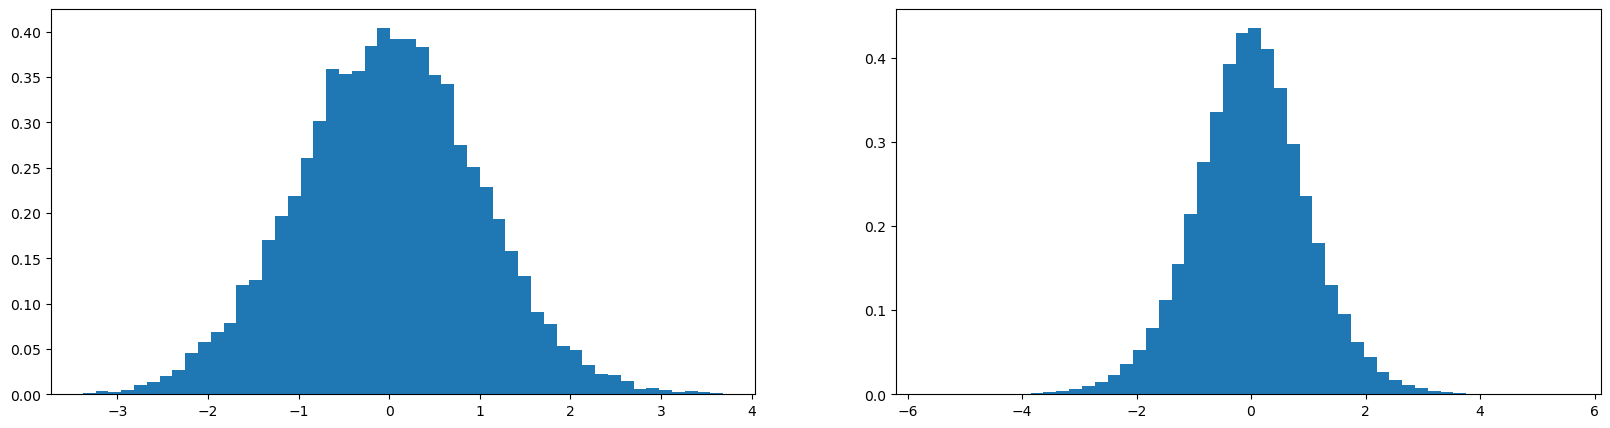

In [105]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);